In [9]:
# Cell 1: Download and preprocess CIFAR-10 and PCam datasets for ResNet34 (224x224)

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import os, random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing



In [8]:
#For reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
# ImageNet normalization stats for ResNet34 pretrained weights [6][9]
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

workers = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {workers}")
# Set the number of workers for DataLoader

# Common transform: resize to 224x224, convert to tensor, normalize
common_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
common_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# CIFAR-10 download and preprocessing
cifar10_train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=common_train_transform
)
cifar10_test = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=common_test_transform
)

# PCam download and preprocessing [1][2][7]
pcam_train = datasets.PCAM(
    root='./data',
    split='train',
    download=True,
    transform=common_train_transform
)
pcam_val = datasets.PCAM(
    root='./data',
    split='val',
    download=True,
    transform=common_test_transform
)
pcam_test = datasets.PCAM(
    root='./data',
    split='test',
    download=True,
    transform=common_test_transform
)

# Example DataLoader setup (adjust batch_size as needed)
batch_size = 900
cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

pcam_train_loader = DataLoader(pcam_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
pcam_val_loader = DataLoader(pcam_val, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
pcam_test_loader = DataLoader(pcam_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.")


Downloading...
From (original): https://drive.google.com/uc?id=1Ka0XfEMiwgCYPdTI-vv6eUElOBnKFKQ2
From (redirected): https://drive.usercontent.google.com/download?id=1Ka0XfEMiwgCYPdTI-vv6eUElOBnKFKQ2&confirm=t&uuid=3840c3e5-d2bf-43dc-bcb2-720f24adf971
To: /home/jovyan/data/pcam/camelyonpatch_level_2_split_train_x.h5.gz
100%|██████████| 6.42G/6.42G [01:30<00:00, 70.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1269yhu3pZDP8UYFQs-NYs3FPwuK-nGSG
To: /home/jovyan/data/pcam/camelyonpatch_level_2_split_train_y.h5.gz
100%|██████████| 21.4k/21.4k [00:00<00:00, 18.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3
From (redirected): https://drive.usercontent.google.com/download?id=1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3&confirm=t&uuid=ceaa5223-4383-4bf6-babb-a6660cd5422f
To: /home/jovyan/data/pcam/camelyonpatch_level_2_split_valid_x.h5.gz
100%|██████████| 806M/806M [00:12<00:00, 62.3MB/s] 
Downloading...
From: https://drive.google.com/u

CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.


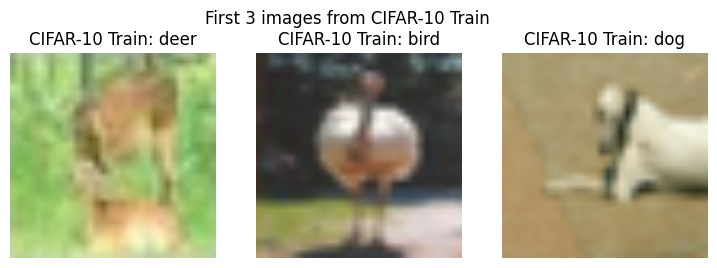

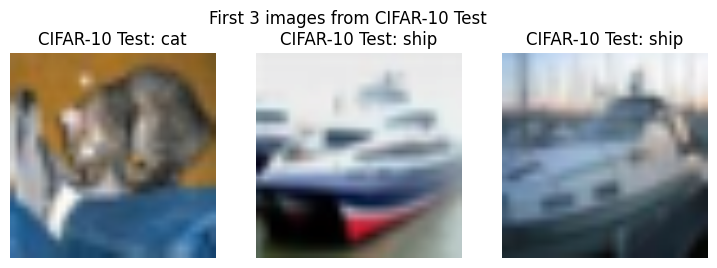

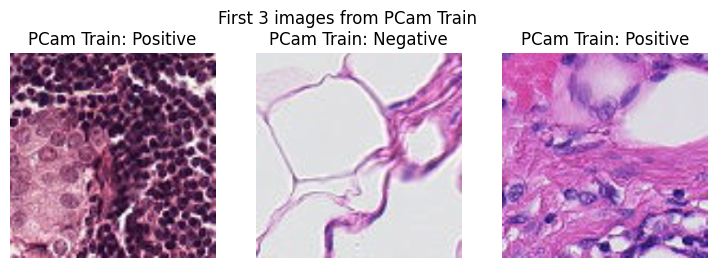

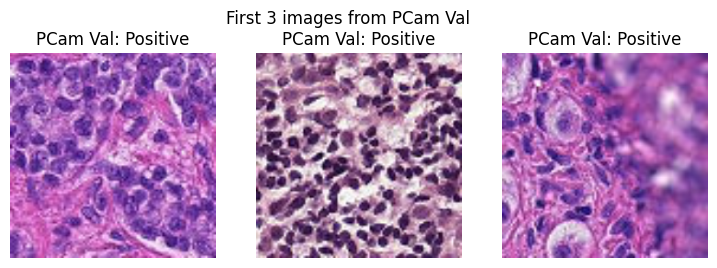

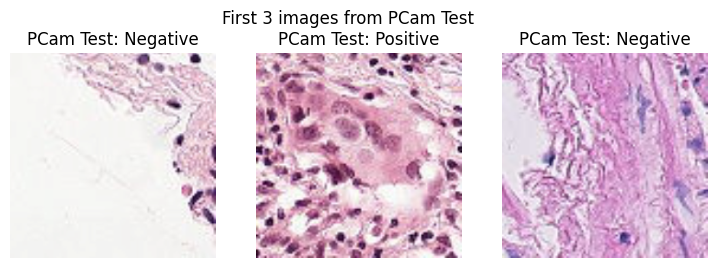

In [4]:
# Helper function to denormalize and show an image
def imshow(img, mean=IMAGENET_MEAN, std=IMAGENET_STD, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Function to show first 3 images from a DataLoader
def show_first_n_images(dataloader, class_names, dataset_name, n=3):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    plt.figure(figsize=(n * 3, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        if class_names is not None:
            plt.title(f"{dataset_name}: {class_names[labels[i]]}")
        else:
            plt.title(f"{dataset_name}: Label {labels[i].item()}")
    plt.suptitle(f"First {n} images from {dataset_name}")
    plt.show()

# Class names for CIFAR-10 and PCam
cifar10_classes = cifar10_train.classes
pcam_classes = ['Negative', 'Positive']

# Show images from each DataLoader
show_first_n_images(cifar10_train_loader, cifar10_classes, "CIFAR-10 Train")
show_first_n_images(cifar10_test_loader, cifar10_classes, "CIFAR-10 Test")
show_first_n_images(pcam_train_loader, pcam_classes, "PCam Train")
show_first_n_images(pcam_val_loader, pcam_classes, "PCam Val")
show_first_n_images(pcam_test_loader, pcam_classes, "PCam Test")


In [10]:
# Cell 2: Initialize ResNet34 model for CIFAR-10 and PCam
def initialize_resnet34(num_classes, device=None):
    """
    Initializes a ResNet34 model with a specified number of output classes.

    Args:
        num_classes (int): Number of output classes for the classification task.
        device (torch.device, optional): The device to load the model onto. Defaults to CUDA if available.

    Returns:
        torch.nn.Module: The initialized ResNet34 model.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    print(f"Initialized ResNet34 for {num_classes} classes on {device} (DataParallel={torch.cuda.device_count() > 1})")
    return model.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models for CIFAR-10 and PCam
cifar_model = initialize_resnet34(num_classes=10, device=device)
pcam_model = initialize_resnet34(num_classes=2, device=device)


Initialized ResNet34 for 10 classes on cuda (DataParallel=True)
Initialized ResNet34 for 2 classes on cuda (DataParallel=True)


In [11]:
torch.save(cifar_model.state_dict(), 'cifar_model.pth')
torch.save(pcam_model.state_dict(), 'pcam_model.pth')
